In [3]:
import utils
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from netgraph import Graph
import numpy as np
from scipy.sparse import csr_matrix



In [ ]:
USA_data = pd.read_csv('data/USA/H095_filtered_USA_votes.csv')

PA,PAV,PAVP,PP = utils.dict_create(USA_data,'icpsr','party_code','rollnumber','cast_code')

In [ ]:
U_thres = np.average(utils.calc_thres(PP, PA, PAV))
USA_inter= utils.calc_inter_edges(PP,PA,PAV)
U_edgelist = utils.edgelist_calc(PA, PAV, U_thres)
U_edgelist = (U_edgelist + USA_inter)
G_USA = nx.from_edgelist(U_edgelist)
list_of_dangle = [node for node in G_USA.nodes if G_USA.degree(node) == 0]
list_of_dangle
edge_list = list(G_USA.edges())
df = pd.DataFrame(edge_list)

# Optionally, if you want to include edge attributes (e.g., weights), you can do:
# df = pd.DataFrame(G_USA.edges(data=True), columns=["Node1", "Node2", "EdgeData"])

# Save to CSV
df.to_csv("USA_95_edge_list.csv", index=False)


[]

In [ ]:
# Create node to community mapping based on party codes
node_to_community = {}
party_to_community = {
    100: 0,  # Democrat
    200: 1,  # Republican 
    328: 2,  # Independent
}

for icpsr in PAVP:
    party_code = PAVP[icpsr][0][2]  # Get party code from first vote
    node_to_community[icpsr] = party_to_community.get(party_code, 3)  # Default 3 for other parties

# Color mapping
community_to_color = {
    0: 'blue',      # Democrats
    1: 'red',       # Republicans
    2: 'green',     # Independents
    3: 'gray'       # Others
}
node_color = {node: community_to_color[community_id] 
              for node, community_id in node_to_community.items()}



/opt/anaconda3/lib/python3.11/site-packages/netgraph/_node_layout.py:1024: RuntimeWarning: invalid value encountered in divide
  directions = deltas / magnitudes[:, np.newaxis]
/opt/anaconda3/lib/python3.11/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


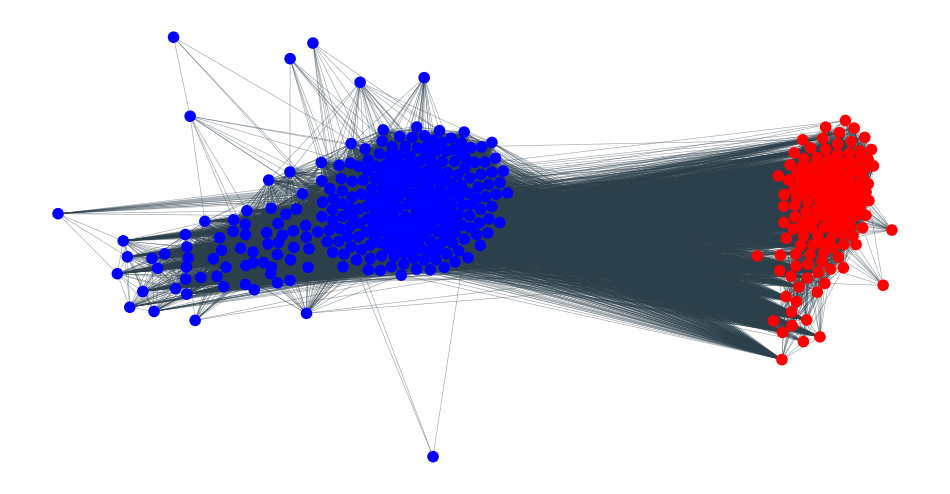

In [ ]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
Graph(G_USA,
      node_color=node_color,
      node_edge_width=0,
      node_size=1,
      edge_width=0.1,
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
      ax=ax)
plt.show()

In [ ]:
# Step 1: Create a list of people (rows) and their corresponding voted bills (columns)
people = list(PAV.keys())  # List of people (1, 2, 3, 4)
votes = set()  # Store the distinct votes/bills
for person in PAV:
    votes.update(PAV[person])  # Add all the bills that each person voted on

votes = sorted(votes)  # Sort the bills to get a consistent column order
vote_to_index = {vote: idx for idx, vote in enumerate(votes)}  # Mapping from bill to column index

# Step 2: Construct the data for the sparse matrix
data = []
row_indices = []
col_indices = []

for person, voted_bills in PAV.items():
    for bill in voted_bills:
        row_indices.append(people.index(person))  # Person's row index
        col_indices.append(vote_to_index[bill])   # Bill's column index
        data.append(1)  # The value in the matrix is 1 if the person voted on the bill

# Step 3: Create the sparse matrix (CSR format)
num_people_us= len(PAV)  # Number of people
num_votes_us = len(votes)  # Number of bills
sparse_matrix_us = csr_matrix((data, (row_indices, col_indices)), shape=(num_people_us, num_votes_us))

dense_matrix = sparse_matrix_us.toarray()

# Convert to DataFrame for easy CSV export
df = pd.DataFrame(dense_matrix)

# Save to CSV
df.to_csv("sparse_matrix_us_95.csv", index=False)